In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [157]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
wind = 'windmill_generated_power(kW/h)'
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,...,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,...,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,...,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,...,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,...,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [158]:
train.dtypes

tracking_id                        object
datetime                           object
wind_speed(m/s)                   float64
atmospheric_temperature(°C)       float64
shaft_temperature(°C)             float64
blades_angle(°)                   float64
gearbox_temperature(°C)           float64
engine_temperature(°C)            float64
motor_torque(N-m)                 float64
generator_temperature(°C)         float64
atmospheric_pressure(Pascal)      float64
area_temperature(°C)              float64
windmill_body_temperature(°C)     float64
wind_direction(°)                 float64
resistance(ohm)                   float64
rotor_torque(N-m)                 float64
turbine_status                     object
cloud_level                        object
blade_length(m)                   float64
blade_breadth(m)                  float64
windmill_height(m)                float64
windmill_generated_power(kW/h)    float64
dtype: object

# Deal with NaN Values:

In [159]:
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

In [160]:
train = train[~train[wind].isnull()]
train.isnull().sum()

### Categorical Features

In [161]:
# Function to impute most occured category and add importance vairable
def impute_categorical(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that vairable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [162]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(train, c)
    
# train[['turbine_status','turbine_status_Imputed','cloud_level','cloud_level_Imputed']].head(10)

### Numerical

In [163]:
train.columns

Index(['tracking_id', 'datetime', 'wind_speed(m/s)',
       'atmospheric_temperature(°C)', 'shaft_temperature(°C)',
       'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'motor_torque(N-m)', 'generator_temperature(°C)',
       'atmospheric_pressure(Pascal)', 'area_temperature(°C)',
       'windmill_body_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'turbine_status', 'cloud_level', 'blade_length(m)',
       'blade_breadth(m)', 'windmill_height(m)',
       'windmill_generated_power(kW/h)', 'turbine_status_Imputed',
       'cloud_level_Imputed'],
      dtype='object')

In [164]:
import datawig

def impute_any(output_column):
    df_train, df_test = datawig.utils.random_split(train)

    #Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=['tracking_id', 'datetime', 'wind_speed(m/s)', 'shaft_temperature(°C)', 'blades_angle(°)',\
                       'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)',\
                       'area_temperature(°C)', 'resistance(ohm)', 'rotor_torque(N-m)', 'turbine_status', 'cloud_level',\
                       'blade_length(m)', 'windmill_height(m)'], # column(s) containing information about the column we want to impute
        output_column= output_column, # the column we'd like to impute values for
        output_path = 'imputer_model' # stores model data and metrics
        )

    #Fit an imputer model on the train data
    imputer.fit(train_df=df_train, num_epochs=50)

    #Impute missing values and return original dataframe with predictions
    imputed = imputer.predict(df_test)
    return imputed
# w = impute_any('wind_speed(m/s)')

In [165]:
for i in train.columns:
    if train[i].isnull().sum()>0:
        mean = train[i].mean()
        train[i].replace(np.nan, mean, inplace=True)

In [166]:
wind = 'windmill_generated_power(kW/h)'
train.shape

(28200, 24)

In [167]:
train.isnull().sum()

tracking_id                       0
datetime                          0
wind_speed(m/s)                   0
atmospheric_temperature(°C)       0
shaft_temperature(°C)             0
blades_angle(°)                   0
gearbox_temperature(°C)           0
engine_temperature(°C)            0
motor_torque(N-m)                 0
generator_temperature(°C)         0
atmospheric_pressure(Pascal)      0
area_temperature(°C)              0
windmill_body_temperature(°C)     0
wind_direction(°)                 0
resistance(ohm)                   0
rotor_torque(N-m)                 0
turbine_status                    0
cloud_level                       0
blade_length(m)                   0
blade_breadth(m)                  0
windmill_height(m)                0
windmill_generated_power(kW/h)    0
turbine_status_Imputed            0
cloud_level_Imputed               0
dtype: int64

In [168]:
train

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_Imputed,cloud_level_Imputed
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,...,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521,0,0
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,...,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275,0,0
2,WM_39146,2019-09-14 14:03:20,95.484724,0.383727,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,...,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342,0,0
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,...,1964.502895,42.744596,ABC,Low,4.857385,0.367140,24.287767,14.851089,0,1
4,WM_21521,2019-05-04 03:13:20,10.722890,0.383727,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,...,1177.516152,13.387289,AAA,Medium,2.254034,0.453374,27.971650,3.519074,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,WM_7814,2019-01-02 02:43:20,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,90.898875,...,1980.861921,45.909054,BB,Medium,2.774335,0.418299,24.590801,9.587934,0,0
28196,WM_32512,2019-07-26 12:53:20,94.196738,24.034329,42.068979,-99.000000,44.285153,43.487939,2207.882276,72.244645,...,1712.840457,36.974913,BB,Low,-3.250989,0.461531,26.051604,4.522195,0,0
28197,WM_5193,2018-12-12 02:13:20,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,94.814637,...,1951.728713,88.319152,D,Medium,2.254034,0.380264,28.533850,11.096599,0,0
28198,WM_12173,2019-02-03 19:13:20,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,90.144418,...,1968.917692,47.562627,BCB,Low,3.001855,0.346447,47.747269,9.373239,0,0


## Numerical Values

In [169]:
train.corr()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_Imputed,cloud_level_Imputed
wind_speed(m/s),1.000000,0.048803,0.038312,-0.003561,0.016169,0.153978,0.375787,0.425292,-0.114828,0.197517,0.026672,0.041446,0.235377,0.150803,0.006298,0.003884,-0.011762,0.062246,0.004224,0.004276
atmospheric_temperature(°C),0.048803,1.000000,0.011277,0.006953,0.005603,0.047454,0.089491,0.110161,-0.020951,0.068143,0.007483,0.015378,0.057722,0.040943,0.000491,0.003494,0.001178,-0.000941,-0.004173,-0.003367
shaft_temperature(°C),0.038312,0.011277,1.000000,-0.009652,0.029967,0.203879,0.071273,0.074638,-0.017856,0.087567,0.017385,0.018197,0.032218,0.027619,0.000131,-0.006120,-0.008723,0.046366,0.005375,-0.006236
blades_angle(°),-0.003561,0.006953,-0.009652,1.000000,-0.025123,-0.064518,-0.137941,-0.044154,0.008840,-0.075710,0.003109,-0.024899,-0.033286,-0.047810,-0.008339,-0.061041,0.002681,-0.153607,0.008685,-0.003409
gearbox_temperature(°C),0.016169,0.005603,0.029967,-0.025123,1.000000,0.132720,0.045035,0.045116,-0.008112,0.058874,0.016401,0.026152,0.021098,0.016505,-0.002439,0.011283,0.003809,0.053017,-0.000724,0.001580
engine_temperature(°C),0.153978,0.047454,0.203879,-0.064518,0.132720,1.000000,0.352092,0.360605,-0.058208,0.337794,0.085820,0.130353,0.208218,0.137072,-0.006539,0.011557,-0.011842,0.271819,-0.009326,-0.004716
motor_torque(N-m),0.375787,0.089491,0.071273,-0.137941,0.045035,0.352092,1.000000,0.934699,-0.204314,0.468298,0.026919,0.188840,0.512974,0.386558,0.004545,0.052929,0.001165,0.503155,-0.010034,0.001080
generator_temperature(°C),0.425292,0.110161,0.074638,-0.044154,0.045116,0.360605,0.934699,1.000000,-0.226918,0.510495,0.034789,0.188868,0.539177,0.368145,0.004852,0.017568,-0.000631,0.390092,-0.012677,0.000534
atmospheric_pressure(Pascal),-0.114828,-0.020951,-0.017856,0.008840,-0.008112,-0.058208,-0.204314,-0.226918,1.000000,-0.085689,-0.008206,-0.024649,-0.121763,-0.088024,0.004657,0.004775,0.002616,-0.012578,0.013016,-0.002323
area_temperature(°C),0.197517,0.068143,0.087567,-0.075710,0.058874,0.337794,0.468298,0.510495,-0.085689,1.000000,0.048667,0.177423,0.266360,0.182864,0.000068,0.022397,-0.005254,0.383173,-0.008965,-0.001081


In [170]:
from scipy import stats

pearson_p = []
for i in train.columns:
    if train[i].dtypes!='O':
        pearson_coef, p_value = stats.pearsonr(train[i], train[wind])
        pearson_p.append([i, pearson_coef, p_value])
pearson_p_df = pd.DataFrame(pearson_p, columns=['Numerical Features', 'Pearson Coefficient', 'p-Value']) 

In [171]:
pearson_p_final = []
for i in range(20):
    if pearson_p_df.loc[i, 'p-Value'] < 0.001:
        pearson_p_final.append(pearson_p_df.loc[i, 'Numerical Features'])
pearson_p_final

['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)',
 'windmill_generated_power(kW/h)']

## Categorical Variables:

c:\users\utshab\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='turbine_status', ylabel='windmill_generated_power(kW/h)'>

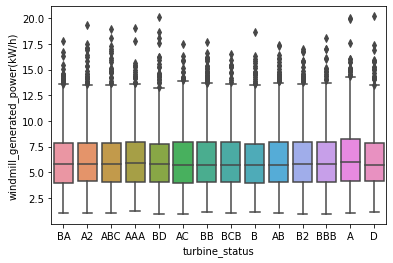

In [172]:
sns.boxplot(train['turbine_status'], train[wind])

c:\users\utshab\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='cloud_level', ylabel='windmill_generated_power(kW/h)'>

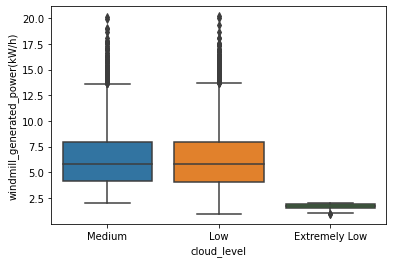

In [173]:
sns.boxplot(train['cloud_level'], train[wind])

In [174]:
cat_group = train[['turbine_status', 'cloud_level', wind]]
cat_group

,turbine_status,cloud_level,windmill_generated_power(kW/h)
0,BA,Medium,6.766521
1,A2,Medium,5.966275
2,ABC,Medium,2.874342
3,ABC,Low,14.851089
4,AAA,Medium,3.519074
...,...,...,...
28195,BB,Medium,9.587934
28196,BB,Low,4.522195
28197,D,Medium,11.096599
28198,BCB,Low,9.373239


In [175]:
cat_group = cat_group.groupby(['cloud_level', 'turbine_status'], as_index=False).mean()
cat_group

,cloud_level,turbine_status,windmill_generated_power(kW/h)
0,Extremely Low,A,1.710368
1,Extremely Low,A2,1.755520
2,Extremely Low,AAA,1.730177
3,Extremely Low,AB,1.733334
4,Extremely Low,ABC,1.638537
5,Extremely Low,AC,1.666935
6,Extremely Low,B,1.674940
7,Extremely Low,B2,1.663634
8,Extremely Low,BA,1.639056
9,Extremely Low,BB,1.731601


In [176]:
grouped_pivot = cat_group.pivot(index='cloud_level',columns='turbine_status')
grouped_pivot

windmill_generated_power(kW/h)                                \
turbine_status                              A        A2       AAA        AB   
cloud_level                                                                   
Extremely Low                        1.710368  1.755520  1.730177  1.733334   
Low                                  6.242574  6.269155  6.180740  6.141102   
Medium                               6.417629  6.218697  6.272872  6.146741   

                                                                            \
turbine_status       ABC        AC         B        B2        BA        BB   
cloud_level                                                                  
Extremely Low   1.638537  1.666935  1.674940  1.663634  1.639056  1.731601   
Low             6.180725  6.143184  6.027012  6.208018  6.179386  6.077367   
Medium          6.107279  6.200374  6.169854  6.274914  6.050773  6.268589   

                                                        
turbine_status       BBB       BCB        BD         D  
cloud_level                                             
Extremely Low   1.720375  1.637298  1.750539  1.659950  
Low             6.059816  6.159232  6.082678  6.014232  
Medium          6.251528  6.174510  6.173877  6.308510

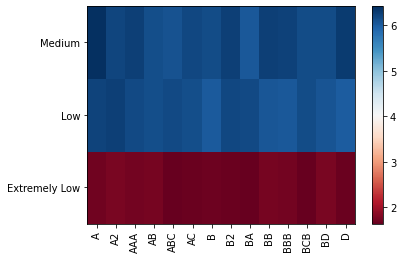

In [177]:
fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

### ANOVA

In [178]:
cat_group2=cat_group[['turbine_status', wind]].groupby(['turbine_status'])
cat_group2.head(1)

,turbine_status,windmill_generated_power(kW/h)
0,A,1.710368
1,A2,1.755520
2,AAA,1.730177
3,AB,1.733334
4,ABC,1.638537
5,AC,1.666935
6,B,1.674940
7,B2,1.663634
8,BA,1.639056
9,BB,1.731601


In [179]:
# turbine_status
f_val, p_val = stats.f_oneway(cat_group2.get_group('A')[wind], cat_group2.get_group('A2')[wind],\
                              cat_group2.get_group('AAA')[wind], cat_group2.get_group('AB')[wind],\
                              cat_group2.get_group('ABC')[wind], cat_group2.get_group('AC')[wind],\
                              cat_group2.get_group('B')[wind], cat_group2.get_group('B2')[wind],\
                              cat_group2.get_group('B2')[wind], cat_group2.get_group('BA')[wind],\
                              cat_group2.get_group('BB')[wind], cat_group2.get_group('BBB')[wind],\
                              cat_group2.get_group('BCB')[wind], cat_group2.get_group('BD')[wind],\
                              cat_group2.get_group('D')[wind])  
 
print( "ANOVA for turbine_status: F=", f_val, ", P =", p_val)

ANOVA for turbine_status: F= 0.000961242227005366 , P = 0.9999999999999999


In [180]:
cat_group3=cat_group[['cloud_level', wind]].groupby(['cloud_level'])
cat_group3.head(1)

,cloud_level,windmill_generated_power(kW/h)
0,Extremely Low,1.710368
14,Low,6.242574
28,Medium,6.417629


In [181]:
# cloud_level
f_val, p_val = stats.f_oneway(cat_group3.get_group('Extremely Low')[wind], cat_group3.get_group('Low')[wind],\
                              cat_group3.get_group('Medium')[wind])  
 
print( "ANOVA for cloud_level: F=", f_val, ", P =", p_val)

ANOVA for cloud_level: F= 17131.83579977556 , P = 3.8624680348850876e-58


### So important variables we derived:
#### Numerical:
- wind_speed(m/s)
- haft_temperature(°C)
- blades_angle(°)
- gearbox_temperature(°C)
- engine_temperature(°C)
- motor_torque(N-m)
- generator_temperature(°C)
- area_temperature(°C)
- wind_direction(°)
- resistance(ohm)
- rotor_torque(N-m)
- blade_breadth(m)

#### Categorical
- cloud_level

In [182]:
from sklearn.model_selection import train_test_split
X = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train.shape, X_test.shape

((19740, 21), (8460, 21))

# Encoding

In [183]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['turbine_status', 'cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),...,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
24945,97.272684,32.007345,42.613104,0.078907,41.854125,41.866622,2128.899487,70.601318,477335.247613,36.583199,...,0,0,1,0,0,3.140693,0.450207,25.790728,0,0
6427,94.413919,23.406481,43.265803,-1.277909,120.194031,46.329418,2327.886937,74.541788,17064.857821,26.112462,...,0,0,0,1,0,2.254034,0.489403,25.887052,1,0
3517,69.037071,24.858446,-99.000000,-0.647725,46.677880,45.940122,2348.049054,79.238049,-195073.991913,43.233737,...,0,0,1,0,0,4.609712,0.468701,27.874443,0,0
7508,21.153605,-99.000000,43.673637,-0.888737,41.907374,44.958709,794.102843,39.363219,118517.176703,23.688782,...,0,0,0,1,0,4.043221,0.427470,42.376050,0,0
12392,-134.056232,8.742545,43.093543,16.581856,41.972448,40.819652,660.056465,38.271468,112276.699963,28.824271,...,0,0,1,0,0,8.130852,0.489099,18.920009,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,93.533272,23.085940,45.989700,6.535103,46.585055,43.222150,2885.997086,93.011962,18125.699210,36.061759,...,0,0,0,1,0,-1.163069,0.369078,25.332530,0,0
19648,94.103037,19.410590,40.252137,86.518712,-22.071476,40.382160,1009.888757,64.305849,15984.874054,23.722555,...,1,0,1,0,0,0.496184,0.456669,24.181214,0,0
9845,95.295968,31.210518,64.120239,69.568566,42.111112,43.349658,2358.726981,76.494074,17352.170139,45.311669,...,0,0,0,1,0,2.254034,0.403863,29.401987,0,0
10799,94.885747,0.383727,42.496316,-1.145072,137.097737,44.685067,2449.633759,77.020491,53185.064883,31.580108,...,0,0,1,0,0,2.744616,0.419271,33.444775,0,0


In [184]:
X_train.shape, X_test.shape

((19740, 36), (8460, 36))

# Feature Scaling

In [185]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [186]:
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),...,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,0.053993,0.798457,-0.265213,0.088480,-0.255689,-0.503823,0.061615,-0.004092,4.605547,0.363414,...,0.0,0.0,1.0,-1.0,0.0,0.048706,0.508886,-0.041237,0.0,0.0
1,0.015362,0.411951,-0.104296,-0.115135,14.538156,0.855430,0.186346,0.100190,-0.017376,-0.593798,...,0.0,0.0,0.0,0.0,0.0,-0.416572,0.893250,-0.008773,1.0,0.0
2,-0.327557,0.477199,-35.178665,-0.020565,0.655238,0.736860,0.198984,0.224473,-2.148084,0.971392,...,0.0,0.0,1.0,-1.0,0.0,0.819580,0.690241,0.661042,0.0,0.0
3,-0.974610,-5.088765,-0.003748,-0.056733,-0.245633,0.437947,-0.775075,-0.830786,1.001604,-0.815365,...,0.0,0.0,0.0,0.0,0.0,0.522311,0.285930,5.548552,0.0,0.0
4,-3.071972,-0.247019,-0.146765,2.565047,-0.233344,-0.822704,-0.859100,-0.859678,0.938925,-0.345890,...,0.0,0.0,1.0,-1.0,0.0,2.667315,0.890265,-2.356892,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19735,0.003462,0.397546,0.567257,1.057349,0.637708,-0.090964,0.536186,0.588990,-0.006721,0.315745,...,0.0,0.0,0.0,0.0,0.0,-2.209713,-0.286666,-0.195665,0.0,0.0
19736,0.011161,0.232383,-0.847289,13.060342,-12.327510,-0.955953,-0.639814,-0.170697,-0.028223,-0.812278,...,1.0,0.0,1.0,-1.0,0.0,-1.339012,0.572255,-0.583696,0.0,0.0
19737,0.027281,0.762649,5.037180,10.516665,-0.207159,-0.052129,0.205677,0.151856,-0.014490,1.161352,...,0.0,0.0,0.0,0.0,0.0,-0.416572,0.054438,1.175874,0.0,0.0
19738,0.021738,-0.622648,-0.294006,-0.095201,17.730281,0.354603,0.262661,0.165787,0.345413,-0.093957,...,0.0,0.0,1.0,-1.0,0.0,-0.159137,0.205533,2.538424,0.0,0.0


# Regressor

In [187]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf2 = RandomForestRegressor(n_estimators=100, random_state=0)

In [188]:
# fit the model
rf.fit(X_train, y_train)

# Predict the Test set results
y_pred = rf.predict(X_test)

In [189]:
from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

94.90803054852252

# Test with test.csv

In [190]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,...,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,...,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,...,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,...,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,...,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,...,28.424722,42.128526,509.795489,1798.141681,-14.365696,NaN,Medium,3.286975,0.407771,20.888674
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,...,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,NaN,0.367823,24.793606
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,...,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,...,29.114305,82.750271,260.578999,1732.883672,NaN,A,Medium,2.247676,0.394680,24.591364


In [191]:
test.isnull().sum()

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64

In [192]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(test, c)

In [193]:
for i in test.columns:
    if test[i].isnull().sum()>0:
        mean = test[i].mean()
        test[i].replace(np.nan, mean, inplace=True)
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,...,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,...,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,...,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,...,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,...,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,...,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,...,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,...,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,...,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [194]:
X_train_final = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y_train_final = train[wind]
X_test_final = test.drop(['tracking_id', 'datetime'], axis=1)


X_train_final.shape, X_test_final.shape

((28200, 21), (12086, 21))

In [195]:
X_test_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),...,wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,...,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,...,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,...,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,...,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,...,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,...,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,...,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,...,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,...,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [196]:
X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),...,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,...,0,0,1,0,0,2.217542,0.314065,24.281689,0,0
1,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,...,0,0,1,0,0,4.210346,0.448494,27.262139,0,0
2,95.484724,0.383727,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,...,0,0,1,0,0,2.719475,0.302321,27.366127,0,0
3,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,...,0,0,0,1,0,4.857385,0.367140,24.287767,0,1
4,10.722890,0.383727,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,...,0,0,1,0,0,2.254034,0.453374,27.971650,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,90.898875,19428.725079,45.429230,...,0,0,1,0,0,2.774335,0.418299,24.590801,0,0
28196,94.196738,24.034329,42.068979,-99.000000,44.285153,43.487939,2207.882276,72.244645,16596.485400,25.142681,...,0,0,0,1,0,-3.250989,0.461531,26.051604,0,0
28197,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,94.814637,19083.881449,45.129442,...,0,1,1,0,0,2.254034,0.380264,28.533850,0,0
28198,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,90.144418,18360.785707,45.603927,...,0,0,0,1,0,3.001855,0.346447,47.747269,0,0


In [197]:
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

In [198]:
rf2.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = rf2.predict(X_test_final)
y_pred_final

array([ 2.59796793,  2.48270968,  3.44344813, ...,  5.25298366,
        5.39991846, 10.49978214])

In [199]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

,windmill_generated_power(kW/h)
0,2.597968
1,2.482710
2,3.443448
3,6.530174
4,3.464208
...,...
12081,6.676162
12082,3.305929
12083,5.252984
12084,5.399918


In [200]:
submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

tracking_id                       0
datetime                          0
windmill_generated_power(kW/h)    0
dtype: int64

In [201]:
submission.shape

(12086, 3)

In [202]:
# submission.to_csv('submission13(removed null targets).csv', index=False)

# Feature Importance

In [203]:
feature_scores = pd.Series(rf2.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

motor_torque(N-m)                0.578643
blades_angle(°)                  0.209552
atmospheric_pressure(Pascal)     0.082683
resistance(ohm)                  0.048440
generator_temperature(°C)        0.029218
engine_temperature(°C)           0.011004
blade_breadth(m)                 0.007447
wind_speed(m/s)                  0.006042
area_temperature(°C)             0.004483
gearbox_temperature(°C)          0.004254
wind_direction(°)                0.003565
windmill_height(m)               0.002538
shaft_temperature(°C)            0.002155
blade_length(m)                  0.002030
rotor_torque(N-m)                0.001941
atmospheric_temperature(°C)      0.001735
windmill_body_temperature(°C)    0.001481
turbine_status_2                 0.000270
turbine_status_14                0.000265
turbine_status_7                 0.000194
turbine_status_9                 0.000193
cloud_level_2                    0.000181
turbine_status_10                0.000177
turbine_status_11                0

In [204]:
# f, ax = plt.subplots(figsize=(30, 24))
# ax = sns.barplot(x=feature_scores, y=X_train.columns, data=train)
# ax.set_title("Visualize feature scores of the features")
# ax.set_yticklabels(feature_scores.index)
# ax.set_xlabel("Feature importance score")
# ax.set_ylabel("Features")
# plt.show()

### More tests

In [205]:
imp0 = ['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)', 'cloud_level']

imp = ['motor_torque(N-m)', 'blades_angle(°)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'generator_temperature(°C)', 'engine_temperature(°C)']

In [206]:
from sklearn.model_selection import train_test_split
X = train[imp0]
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train.shape, X_test.shape

# Encoding

import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
# X_train

# X_train.shape, X_test.shape

# Feature Scaling

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

X_train

# Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf2 = RandomForestRegressor(n_estimators=100, random_state=0)

# fit the model
rf2.fit(X_train, y_train)

# Predict the Test set results
y_pred = rf2.predict(X_test)

from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

95.36531044873968

In [207]:
X_train_final = train[imp0]
y_train_final = train[wind]
X_test_final = test[imp0]


X_train_final.shape, X_test_final.shape

X_test_final

X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

rf2.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = rf2.predict(X_test_final)
y_pred_final

y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

submission.shape

# submission.to_csv('submission14(removed null targets_imp0).csv', index=False)

(12086, 3)